In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("azminetoushikwasi/supplygraph-supply-chain-planning-using-gnns")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\20200820\.cache\kagglehub\datasets\azminetoushikwasi\supplygraph-supply-chain-planning-using-gnns\versions\2


In [482]:
import pandas as pd
path = r"C:\Users\20200820\.cache\kagglehub\datasets\azminetoushikwasi\supplygraph-supply-chain-planning-using-gnns\versions\2\Raw Dataset/"

# Nodes
nodes = pd.read_csv(path + r"Nodes\Nodes.csv")   
#edges = pd.read_csv(path + r"Edges\Edges (Plant).csv")

delivery_to_distributor = pd.read_csv(path + r"Temporal Data\Unit\Delivery To distributor.csv")
factory_issue = pd.read_csv(path + r"Temporal Data\Unit\factory issue.csv")
production = pd.read_csv(path + r"Temporal Data\Unit\Production .csv")
sales_order = pd.read_csv(path + r"Temporal Data\Unit\Sales order.csv")

In [483]:
len(nodes)

40

In [ ]:
import pandas as pd
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

path = r"C:\Users\20200820\.cache\kagglehub\datasets\azminetoushikwasi\supplygraph-supply-chain-planning-using-gnns\versions\2\Raw Dataset\Temporal Data\Unit/"

production = pd.read_csv(path + "Production .csv")
factory_issue = pd.read_csv(path + "factory issue.csv")
delivery = pd.read_csv(path + "Delivery To distributor.csv")
sales_order = pd.read_csv(path + "Sales order.csv")

products = [col for col in production.columns if col != "Date"]
product_to_id = {prod: i for i, prod in enumerate(products)}

def transform_temporal(df, mapping):
    df_no_date = df.drop(columns=["Date"])
    return df_no_date.rename(columns=mapping)

X_prod = transform_temporal(production, product_to_id)
X_issue = transform_temporal(factory_issue, product_to_id)
X_delivery = transform_temporal(delivery, product_to_id)
X_sales = transform_temporal(sales_order, product_to_id)  

X_prod_np = X_prod.to_numpy()
X_issue_np = X_issue.to_numpy()
X_delivery_np = X_delivery.to_numpy()
X_sales_np = X_sales.to_numpy()

# shape: [T, N, F] = [time_steps, num_nodes, num_features]
X = np.stack([X_prod_np, X_issue_np, X_delivery_np, X_sales_np], axis=-1)

y = X_sales_np[1:]       
X = X[:-1]

print("X shape:", X.shape)  # (T-1, N, 4)
print("y shape:", y.shape)  # (T-1, N)


X shape: (220, 41, 4)
y shape: (220, 41)


In [495]:
# X = X[:150]
# X.shape
# y = y[:150]

In [496]:
train = int(0.8 * X.shape[0])

X_train, X_test = X[:train], X[train:]
y_train, y_test = y[:train], y[train:]

In [497]:
from sklearn.preprocessing import StandardScaler
import numpy as np

T, N, F = X_train.shape

# Prepare scaled containers
X_train_scaled = np.zeros_like(X_train)
y_train_scaled = np.zeros_like(y_train)
X_test_scaled = np.zeros_like(X_test)
y_test_scaled = np.zeros_like(y_test)

scaler_X_per_product = []
scaler_y_per_product = []

for node_idx in range(N):
    # Fit a scaler for features of this product
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_node = X_train[:, node_idx, :]  # (T, F)
    y_node = y_train[:, node_idx].reshape(-1, 1)
    
    X_train_scaled[:, node_idx, :] = scaler_X.fit_transform(X_node)
    y_train_scaled[:, node_idx] = scaler_y.fit_transform(y_node).ravel()
    
    # Scale test data using same scaler
    X_test_scaled[:, node_idx, :] = scaler_X.transform(X_test[:, node_idx, :])
    y_test_scaled[:, node_idx] = scaler_y.transform(y_test[:, node_idx].reshape(-1, 1)).ravel()
    
    scaler_X_per_product.append(scaler_X)
    scaler_y_per_product.append(scaler_y)


In [498]:
edges1 = pd.read_csv(r"C:\Users\20200820\.cache\kagglehub\datasets\azminetoushikwasi\supplygraph-supply-chain-planning-using-gnns\versions\2/Raw Dataset/Edges/Edges (Plant).csv")
edges2 = pd.read_csv(r"C:\Users\20200820\.cache\kagglehub\datasets\azminetoushikwasi\supplygraph-supply-chain-planning-using-gnns\versions\2/Raw Dataset/Edges/Edges (Product Group).csv")
edges3 = pd.read_csv(r"C:\Users\20200820\.cache\kagglehub\datasets\azminetoushikwasi\supplygraph-supply-chain-planning-using-gnns\versions\2/Raw Dataset/Edges/Edges (Product Sub-Group).csv")
edges4 = pd.read_csv(r"C:\Users\20200820\.cache\kagglehub\datasets\azminetoushikwasi\supplygraph-supply-chain-planning-using-gnns\versions\2/Raw Dataset/Edges/Edges (Storage Location).csv")

edges1['node1'] = edges1['node1'].astype(str)
edges1['node2'] = edges1['node2'].astype(str)

edges2['node1'] = edges2['node1'].astype(str)
edges2['node2'] = edges2['node2'].astype(str)

edges3['node1'] = edges3['node1'].astype(str)
edges3['node2'] = edges3['node2'].astype(str)

edges4['node1'] = edges4['node1'].astype(str)
edges4['node2'] = edges4['node2'].astype(str)

edges1['node1'] = edges1['node1'].map(product_to_id)
edges1['node2'] = edges1['node2'].map(product_to_id)

edges2['node1'] = edges2['node1'].map(product_to_id)
edges2['node2'] = edges2['node2'].map(product_to_id)

edges3['node1'] = edges3['node1'].map(product_to_id)
edges3['node2'] = edges3['node2'].map(product_to_id)

edges4['node1'] = edges4['node1'].map(product_to_id)
edges4['node2'] = edges4['node2'].map(product_to_id)

edge_index_1 = edges1[['node1', 'node2']].to_numpy().T.astype(np.int64)
edge_index_2 = edges2[['node1', 'node2']].to_numpy().T.astype(np.int64)
edge_index_3 = edges3[['node1', 'node2']].to_numpy().T.astype(np.int64)
edge_index_4 = edges4[['node1', 'node2']].to_numpy().T.astype(np.int64)

#edge_index = np.hstack([edge_index_1, edge_index_2, edge_index_3, edge_index_4])
edge_index = np.hstack([edge_index_1])
num_nodes = len(product_to_id)

train_dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=np.ones(edge_index.shape[1]),
    features=X_train_scaled,
    targets=y_train_scaled
)

test_dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=np.ones(edge_index.shape[1]),
    features=X_test_scaled,
    targets=y_test_scaled
)


C:\Users\20200820\AppData\Local\Temp\ipykernel_23132\952732320.py:30: RuntimeWarning: invalid value encountered in cast
  edge_index_1 = edges1[['node1', 'node2']].to_numpy().T.astype(np.int64)
C:\Users\20200820\AppData\Local\Temp\ipykernel_23132\952732320.py:31: RuntimeWarning: invalid value encountered in cast
  edge_index_2 = edges2[['node1', 'node2']].to_numpy().T.astype(np.int64)
C:\Users\20200820\AppData\Local\Temp\ipykernel_23132\952732320.py:32: RuntimeWarning: invalid value encountered in cast
  edge_index_3 = edges3[['node1', 'node2']].to_numpy().T.astype(np.int64)
C:\Users\20200820\AppData\Local\Temp\ipykernel_23132\952732320.py:33: RuntimeWarning: invalid value encountered in cast
  edge_index_4 = edges4[['node1', 'node2']].to_numpy().T.astype(np.int64)


## Spectral analysis

In [501]:
from scipy.sparse import coo_matrix
import pygsp as pg

# 1) Build sparse, symmetric adjacency matrix
N = num_nodes
row, col = edge_index[0], edge_index[1]
W = coo_matrix((np.ones(row.size), (row, col)), shape=(N, N)).tocsr()
W.data[:] = 1.0                             # binarize since graph is unweighted
W = ((W + W.T) > 0).astype(float).tocsr()   # symmetrize
W.setdiag(0); W.eliminate_zeros()

# 2) Create graph and get normalized Laplacian eigenbasis
G = pg.graphs.Graph(W)           
G.compute_laplacian(lap_type = 'normalized')
# L = G.L.toarray()             
G.compute_fourier_basis()          # gives G.U (eigenvectors), G.e (eigenvalues)

# 3) GFT at each timestep
f_sales = 3
X_tn = X_train_scaled[:, :, f_sales].astype(float)    # (T, N)
U, lam = G.U, G.e                                    
X_hat = G.gft(X_tn.T).T                                # GFT at every t

ValueError: negative axis 0 index: -9223372036854775808

In [500]:
num_nodes

1

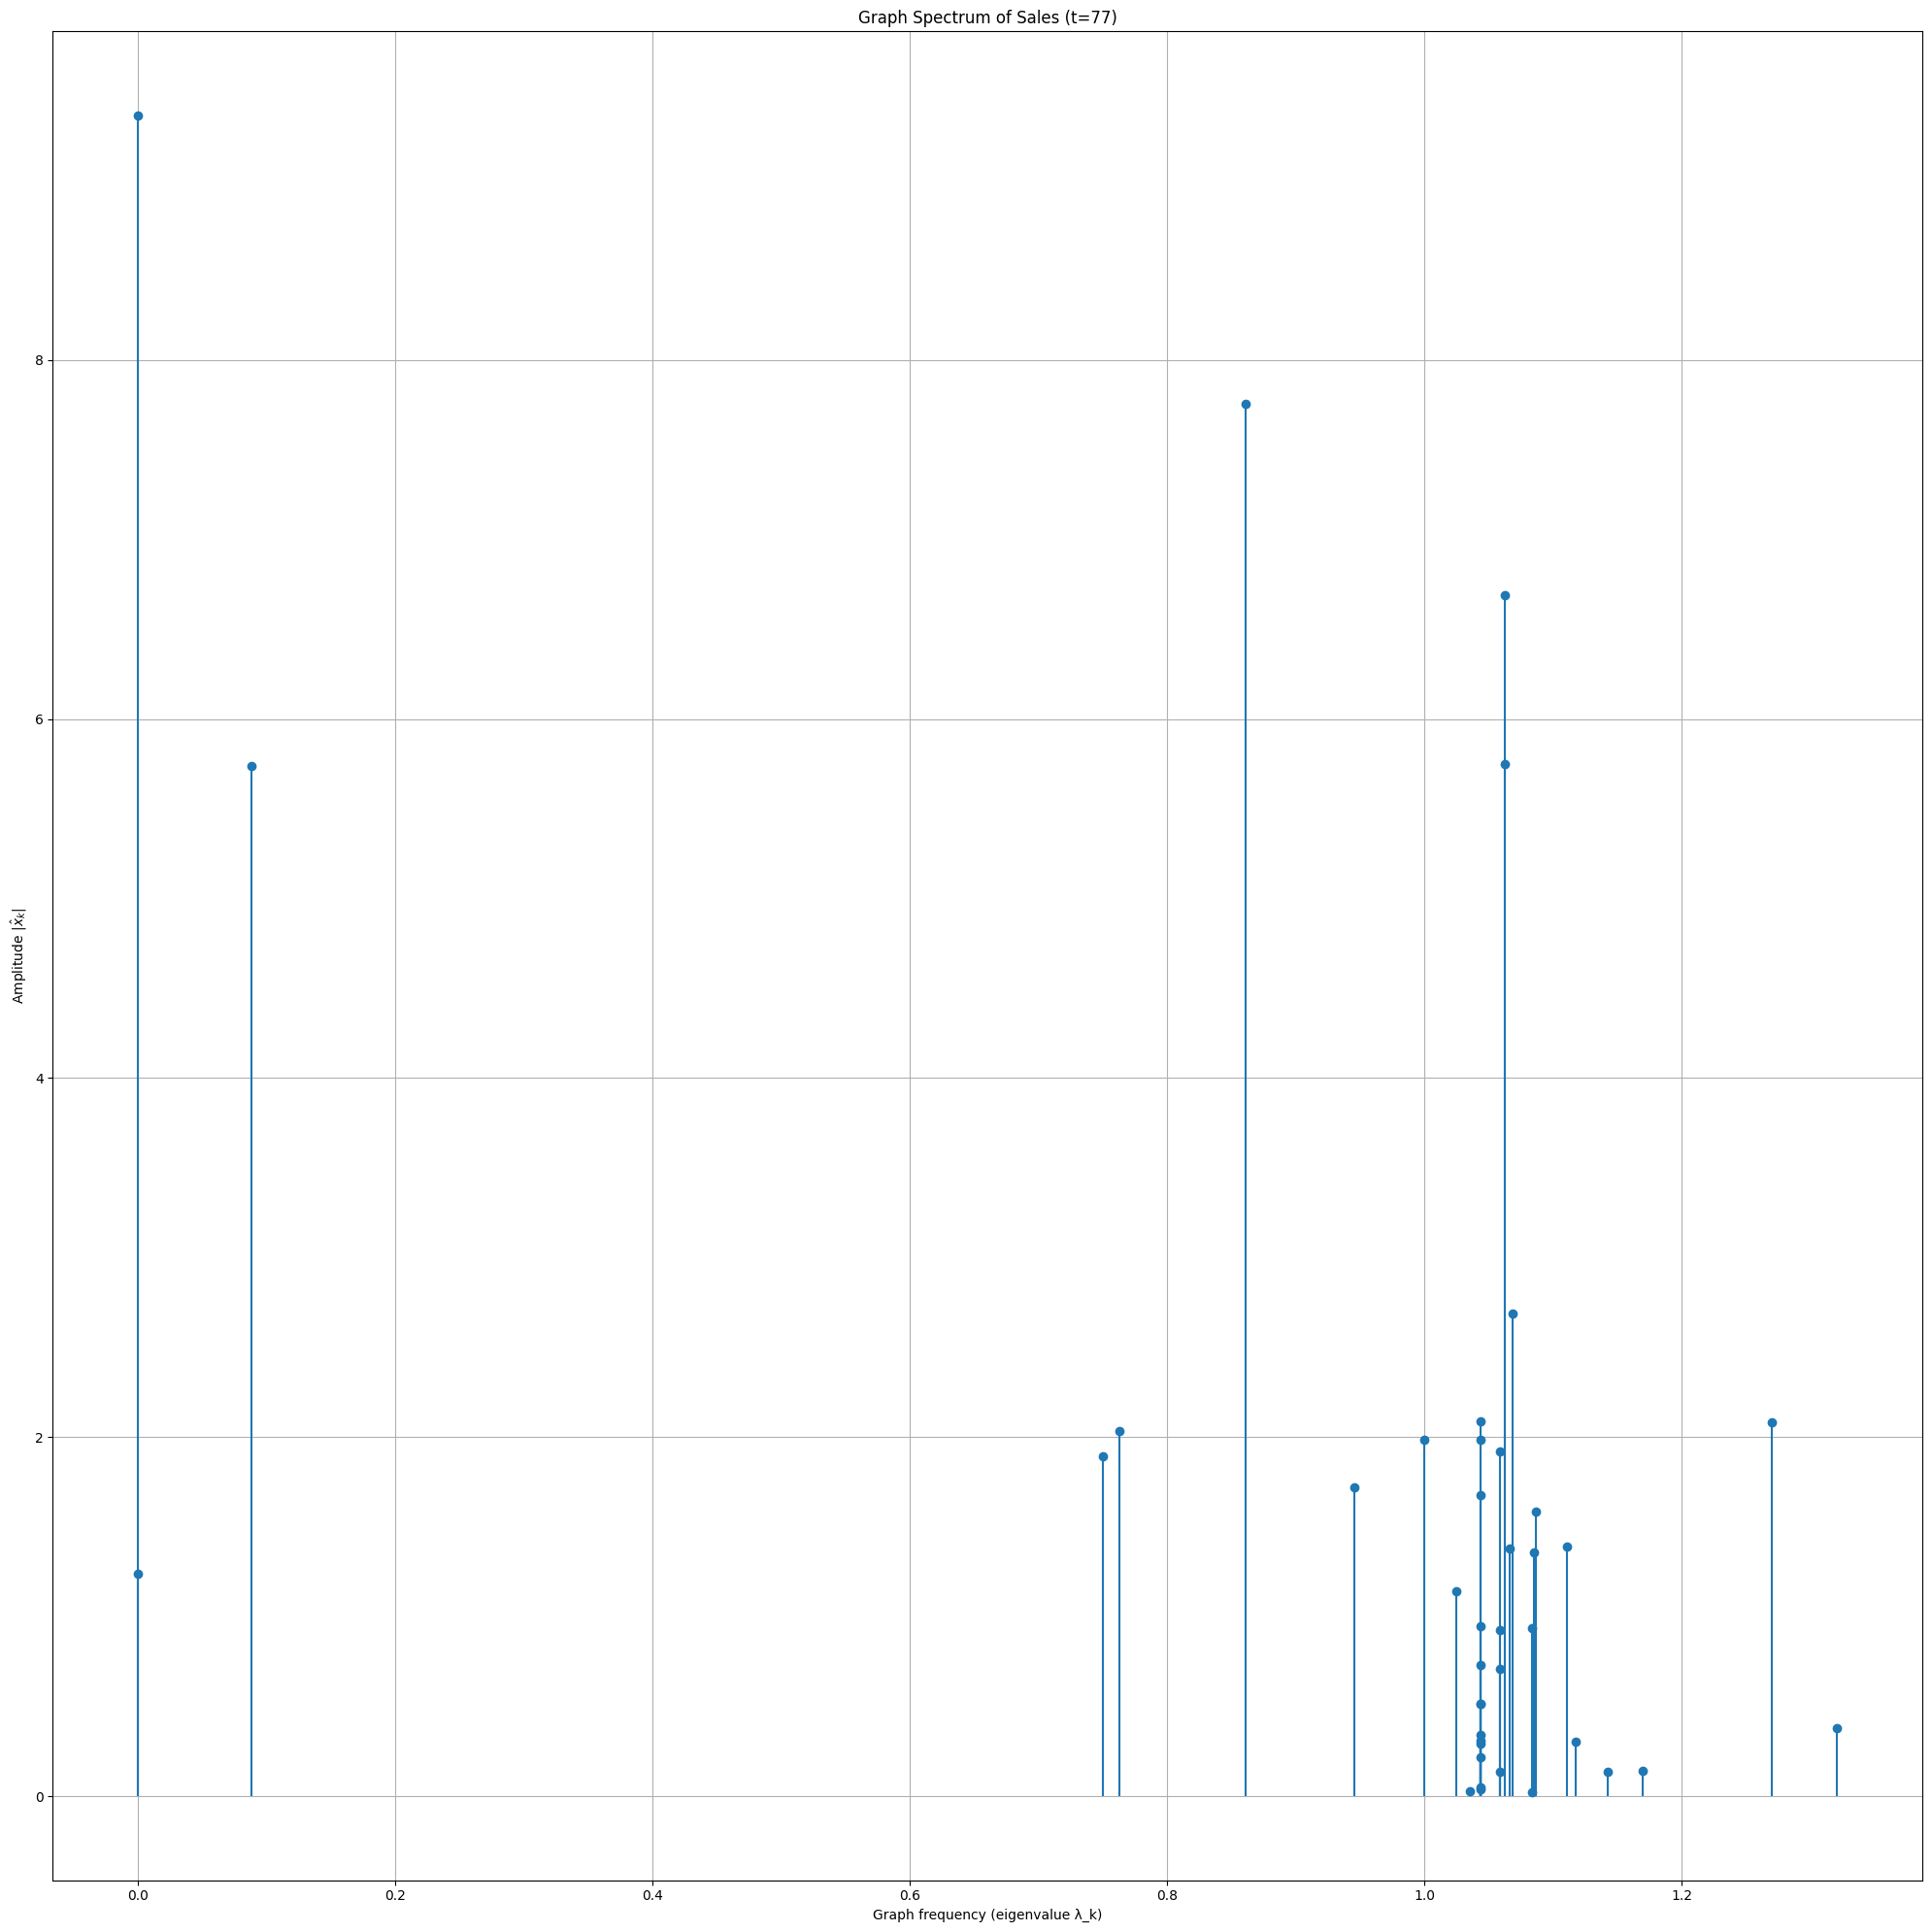

In [480]:
import matplotlib.pyplot as plt

def plot_spectrum_at(t):
    import matplotlib.pyplot as plt
    xhat_t = X_hat[t]                                  # \hat{x}_k at time t
    plt.figure(figsize=(20,20))
    plt.grid()
    plt.stem(lam, np.abs(xhat_t), basefmt=" ")
    plt.xlabel("Graph frequency (eigenvalue λ_k)")
    plt.ylabel(r"Amplitude $|\hat{x}_k|$")
    plt.title(f"Graph Spectrum of Sales (t={t})")
    plt.tight_layout(); plt.show()

# example
plot_spectrum_at(77)

In [472]:
len(lam)

41

In [471]:
len(np.unique(lam))

34

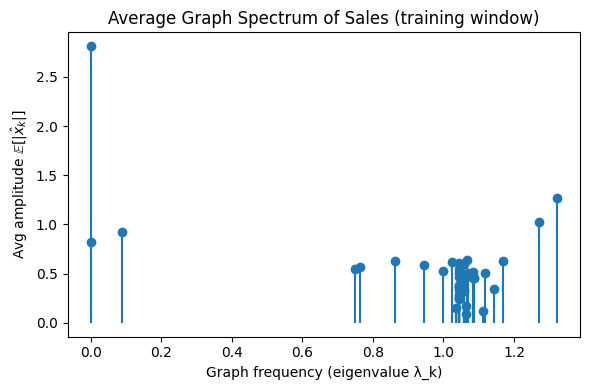

In [460]:
avg_amp = np.mean(np.abs(X_hat), axis=0)              # mean over time
plt.figure(figsize=(6,4))
plt.stem(lam, avg_amp, basefmt=" ")
plt.xlabel("Graph frequency (eigenvalue λ_k)")
plt.ylabel(r"Avg amplitude $\mathbb{E}[|\hat{x}_k|]$")
plt.title("Average Graph Spectrum of Sales (training window)")
plt.tight_layout(); plt.show()

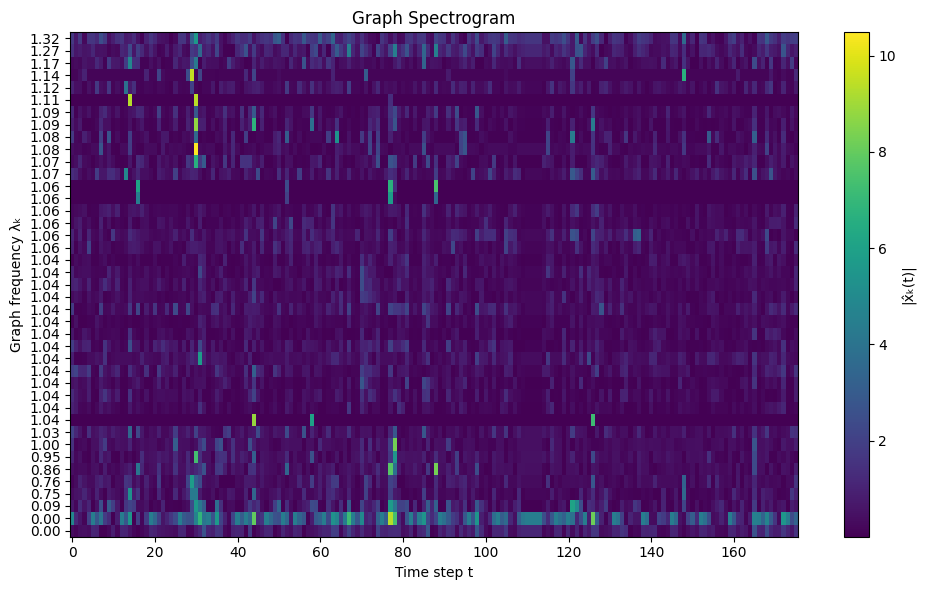

In [461]:
A = np.abs(X_hat)                   # (T, N)
idx = np.argsort(lam)               # sort by eigenvalue
lam_sorted = lam[idx]
A_sorted = A[:, idx].T              # (N, T)  

plt.figure(figsize=(10,6))
plt.imshow(A_sorted, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='|x̂ₖ(t)|')

# one row per eigenmode; label rows by λ_k
N = len(lam_sorted)
plt.yticks(np.arange(N), [f'{l:.2f}' for l in lam_sorted])
plt.xlabel('Time step t')
plt.ylabel('Graph frequency λₖ')
plt.title('Graph Spectrogram')
plt.tight_layout()
plt.show()

## Full Graph visualization

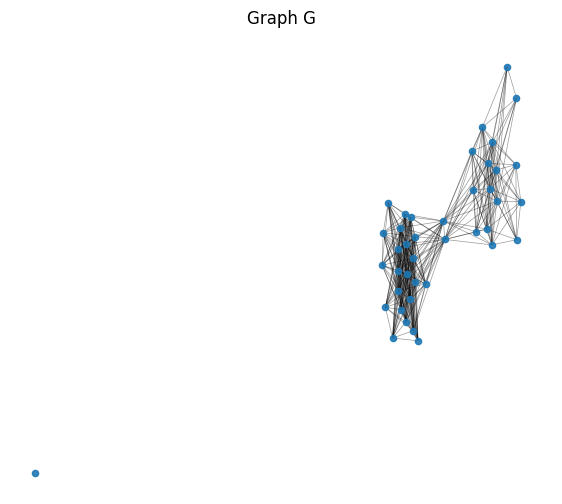

In [462]:
import networkx as nx

G_nx = nx.from_scipy_sparse_array(W)  
pos = nx.spring_layout(G_nx, seed=42)  

# plain graph plot 
plt.figure(figsize=(7,6))
nx.draw_networkx_edges(G_nx, pos, width=0.5, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, node_size=20, alpha=0.9)
plt.title("Graph G")
plt.axis("off")
plt.show()

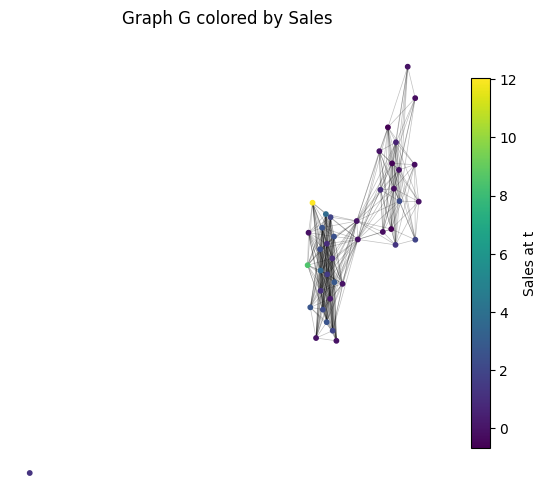

In [463]:

# color nodes by the sales signal at a time t
t = 77
x_t = X_tn[t]  # shape (N,)

plt.figure(figsize=(7,6))
nx.draw_networkx_edges(G_nx, pos, width=0.5, alpha=0.25)
nodes = nx.draw_networkx_nodes(
    G_nx, pos,
    node_color=x_t,           # colors by sales value
    cmap="viridis",
    node_size=10
)
plt.colorbar(nodes, shrink=0.8, label="Sales at t")
plt.title("Graph G colored by Sales")
plt.axis("off")
plt.show()

In [464]:
n = G_nx.number_of_nodes()
m = G_nx.number_of_edges()

is_complete = m == n*(n-1)/2
density = nx.density(G_nx)

print(f"Nodes: {n}, Edges: {m}")
print(f"Density: {density:.3f}")
print("Fully connected (complete):", is_complete)

Nodes: 41, Edges: 360
Density: 0.439
Fully connected (complete): False


## Visualize largest component (useful when the graph is densly connected)

nodes: 41 edges: 360 isolates: 1


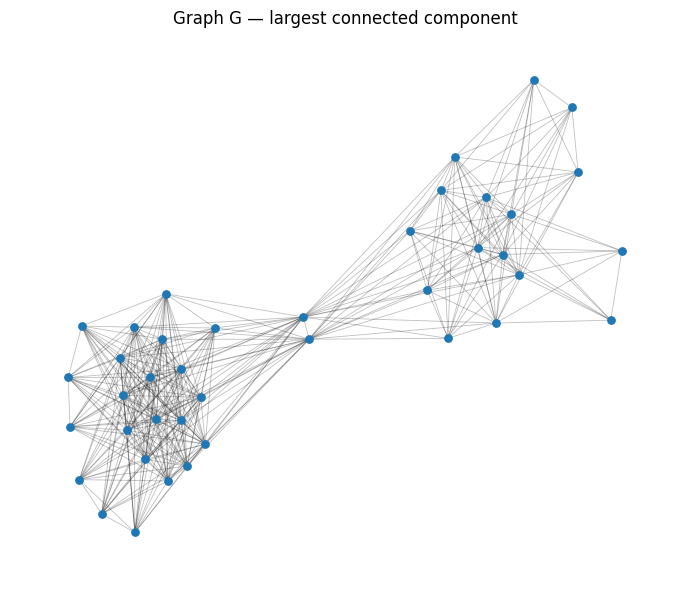

In [465]:
import networkx as nx

G_nx = nx.from_scipy_sparse_array(W)

# Diagnose isolates/components
print("nodes:", G_nx.number_of_nodes(),
      "edges:", G_nx.number_of_edges(),
      "isolates:", nx.number_of_isolates(G_nx))

# Largest connected component for plotting
largest_cc = max(nx.connected_components(G_nx), key=len)
H = G_nx.subgraph(largest_cc).copy()

pos = nx.spring_layout(H, seed=42)  # 

plt.figure(figsize=(7,6))
nx.draw_networkx_edges(H, pos, width=0.6, alpha=0.25)
nx.draw_networkx_nodes(H, pos, node_size=28)
plt.title("Graph G — largest connected component")
plt.axis("off")
plt.tight_layout()
plt.show()

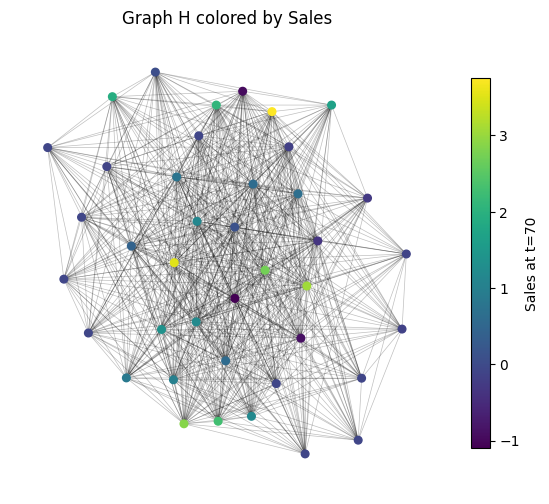

In [441]:
t = 70

x_map = {i: X_tn[t, i] for i in range(X_tn.shape[1])}
nodelist = list(H.nodes())
x_vals = np.array([x_map[n] for n in nodelist])
assert len(nodelist) == len(x_vals) == H.number_of_nodes()

# Draw, explicitly passing nodelist so colors line up
plt.figure(figsize=(7,6))
nx.draw_networkx_edges(H, pos, width=0.5, alpha=0.25)
nodes = nx.draw_networkx_nodes(
    H, pos,
    nodelist=nodelist,
    node_color=x_vals,   
    cmap="viridis",
    node_size=30
)
plt.colorbar(nodes, shrink=0.8, label=f"Sales at t={t}")
plt.title("Graph H colored by Sales")
plt.axis("off")
plt.show()

In [442]:
n = H.number_of_nodes()
m = H.number_of_edges()

is_complete = m == n*(n-1)/2
density = nx.density(H)

print(f"Nodes: {n}, Edges: {m}")
print(f"Density: {density:.3f}")
print("Fully connected (complete):", is_complete)

Nodes: 40, Edges: 684
Density: 0.877
Fully connected (complete): False
